In [1]:
import pandas as pd
import numpy as np
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import re
import string
from nltk.corpus import stopwords
from tensorflow.keras.utils import plot_model
warnings.filterwarnings('ignore')


## Predicting words in audio files 
* We are going to try predict words in audio files based on their mfcc features.
* The approach is similar to image captioning where we used image embeddings as input features to caption the images

In [2]:
data = pd.read_csv("../input/french-single-speaker-speech-dataset/transcript.txt",sep = "|",header=None)
data.columns = ["Wav_path","Prompts","Normalized Script","Audio duration"]
data["Wav_path"] = "../input/french-single-speaker-speech-dataset/" + data["Wav_path"]
data.head()

,Wav_path,Prompts,Normalized Script,Audio duration
0,../input/french-single-speaker-speech-dataset/...,Chapitre I La Charybde du faubourg Saint-Antoi...,Chapitre I La Charybde du faubourg Saint-Antoi...,7.63
1,../input/french-single-speaker-speech-dataset/...,Les deux plus mémorables barricades que l'obse...,Les deux plus mémorables barricades que l'obse...,9.41
2,../input/french-single-speaker-speech-dataset/...,"Ces deux barricades, symboles toutes les deux,...","Ces deux barricades, symboles toutes les deux,...",6.27
3,../input/french-single-speaker-speech-dataset/...,sortirent de terre lors de la fatale insurrect...,sortirent de terre lors de la fatale insurrect...,9.24
4,../input/french-single-speaker-speech-dataset/...,"Il arrive quelquefois que, même contre les pri...","Il arrive quelquefois que, même contre les pri...",6.54


## Data preprocessing

In [3]:
stopwords = stopwords.words('french')
punct = list(string.punctuation)

In [4]:
def preprocessing_data(data):
    data["Prompts"] = data["Prompts"].apply(lambda x: re.sub('[^a-zA-Z]',' ',x))
    data["Prompts"] = data["Prompts"].apply(lambda x: x.lower())
    data["Prompts"] = data["Prompts"].apply(lambda x: x.replace("[^A-Za-z]",""))
    data["Prompts"] = data["Prompts"].apply(lambda x: x.replace("'",""))
    data["Prompts"] = data["Prompts"].apply(lambda x: x.replace("\s+"," "))
    data['Prompts'] = data['Prompts'].apply(lambda x: " ".join([word for word in x.split() if word not in punct]))
    data["Prompts"] = data["Prompts"].apply(lambda x: " ".join([word for word in x.split() if word not in stopwords and len(word)>1]))
    data['Prompts'] = "start "+data['Prompts']+" end"
    return data

In [5]:
data = preprocessing_data(data)
data = data.sample(2000,random_state = 0 )
data.head(5)

,Wav_path,Prompts,Normalized Script,Audio duration
7913,../input/french-single-speaker-speech-dataset/...,start videmment comment pouvait conna tre puis...,– videmment. Mais comment pouvait-il la connaî...,7.91
1811,../input/french-single-speaker-speech-dataset/...,start alise presque id al entend angleterre mo...,Il réalise presque l'idéal de ce qu'on entend ...,9.12
4923,../input/french-single-speaker-speech-dataset/...,start cet argent bien voici toute chose jais b...,cet argent est bien à toi. Voici toute la chos...,7.59
4695,../input/french-single-speaker-speech-dataset/...,start toute vie concentrait cette heure asseya...,Toute sa vie se concentrait dans cette heure-l...,4.94
7159,../input/french-single-speaker-speech-dataset/...,start deux heures pourrai quitter place apr av...,"deux heures, je pourrai moi-même quitter la pl...",9.31


## Tokenization

In [6]:
prompts = data["Prompts"].to_list()

In [7]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(prompts)
vocab_size = len(tokenizer.word_index)+1
max_length = data["Prompts"].apply(lambda x: len(x.split(" "))).max()

In [8]:
sequences = tokenizer.texts_to_sequences(prompts)

## Creating MFCC features

In [9]:
def create_mfcc_features(path):
    mfccs = []
    try:
        x , sr = librosa.load(path, res_type='kaiser_fast')
        mfccs = librosa.feature.mfcc(y=x, sr=sr, n_mfcc=128)
        mfccs = np.mean(mfccs.T,axis=0)
    except:
        print('Error reading audio')
    return mfccs

In [10]:
features = []
for path in data["Wav_path"]:
    x = create_mfcc_features(path)
    x = x.reshape(16, 8, 1)
    features.append(x)

In [11]:
np.array(features).shape

(2000, 16, 8, 1)

## Defining the inputs and outputs to model
* Inputs
  * audio feature
  * prompts[:-1]
* Output 
  * word


##### We'll see an example of how the input features are created for each audio file

In [12]:
X1 = []
X2 = []
y = []
j = 0
for feature in features:
    if j == 1:
        break
    seq = tokenizer.texts_to_sequences([prompts[j]])[0]
    j = j+1
    for i in range(1,len(seq)):
        in_seq, out_seq = seq[:i], seq[i]
        #in_seq = pad_sequences([in_seq], maxlen=max_length)
        out_seq = to_categorical([out_seq], num_classes=vocab_size)
        X1.append(feature)
        X2.append(in_seq)
        y.append(out_seq)

In [13]:
input2 = []
for i in X2:
    input2.append(tokenizer.sequences_to_texts([i]))
    
eg_data = pd.DataFrame()
eg_data["input_mfcc"] = X1
eg_data["input_prompts"]= input2
eg_data["output"] = y

In [14]:
eg_data.head()

,input_mfcc,input_prompts,output
0,"[[[-364.45276], [89.522064], [-9.886822], [30....",[start],"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,"[[[-364.45276], [89.522064], [-9.886822], [30....",[start videmment],"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,"[[[-364.45276], [89.522064], [-9.886822], [30....",[start videmment comment],"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,"[[[-364.45276], [89.522064], [-9.886822], [30....",[start videmment comment pouvait],"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,"[[[-364.45276], [89.522064], [-9.886822], [30....",[start videmment comment pouvait conna],"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0,..."


#### Creating features for all audio files

In [15]:
X1 = []
X2 = []
y = []
j = 0
for feature in features:
    if j == 2000:
        break
    seq = tokenizer.texts_to_sequences([prompts[j]])[0]
    j = j+1
    for i in range(1,len(seq)):
        in_seq, out_seq = seq[:i], seq[i]
        in_seq = pad_sequences([in_seq], maxlen=max_length)
        out_seq = to_categorical([out_seq], num_classes=vocab_size)
        X1.append(feature)
        X2.append(in_seq)
        y.append(out_seq)
X1 = np.array(X1)
X2 = np.array(X2)
y = np.array(y)

In [16]:
X1.shape,X2.shape,y.shape

((23373, 16, 8, 1), (23373, 1, 33), (23373, 1, 6364))

In [18]:
X2 = X2.reshape(23373,33)
y = y.reshape(23373,6364)

In [19]:
final = pd.DataFrame({"X1": list(X1),"X2":list(X2),"y":list(y)})

In [20]:
final.head()

,X1,X2,y
0,"[[[-364.45276], [89.522064], [-9.886822], [30....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,"[[[-364.45276], [89.522064], [-9.886822], [30....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[[[-364.45276], [89.522064], [-9.886822], [30....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,"[[[-364.45276], [89.522064], [-9.886822], [30....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[[[-364.45276], [89.522064], [-9.886822], [30....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."


In [21]:
wav_path = data["Wav_path"].to_list()

In [22]:
split = int(len(prompts)*0.8)
X_train = [X1[:split],X2[:split]]
y_train = y[:split]

X_test = [X1[split:],X2[split:]]
y_test = y[split:]

## Model

In [25]:
input1 = Input(shape=(16,8,1))
input2 = Input(shape=(max_length,))

feature_model = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding = "same")(input1)
feature_model = MaxPooling2D(2, 2)(feature_model)
feature_model = Conv2D(filters=8, kernel_size=(3, 3), activation='relu', padding = "same")(feature_model)
feature_model = MaxPooling2D(2, 2)(feature_model)
feature_model = Flatten()(feature_model)
feature_model = Dense(128, activation='relu')(feature_model)
feature_model_reshaped = Reshape((1, 128), input_shape=(128,))(feature_model)

prompt_features = Embedding(vocab_size, 128, mask_zero=False)(input2)
prompt_features = LSTM(128)(prompt_features)
prompt_features = Dropout(0.5)(prompt_features)

x = add([prompt_features, feature_model])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)

audio_model = Model(inputs=[input1,input2], outputs=output)
audio_model.compile(loss='categorical_crossentropy',optimizer='adam')


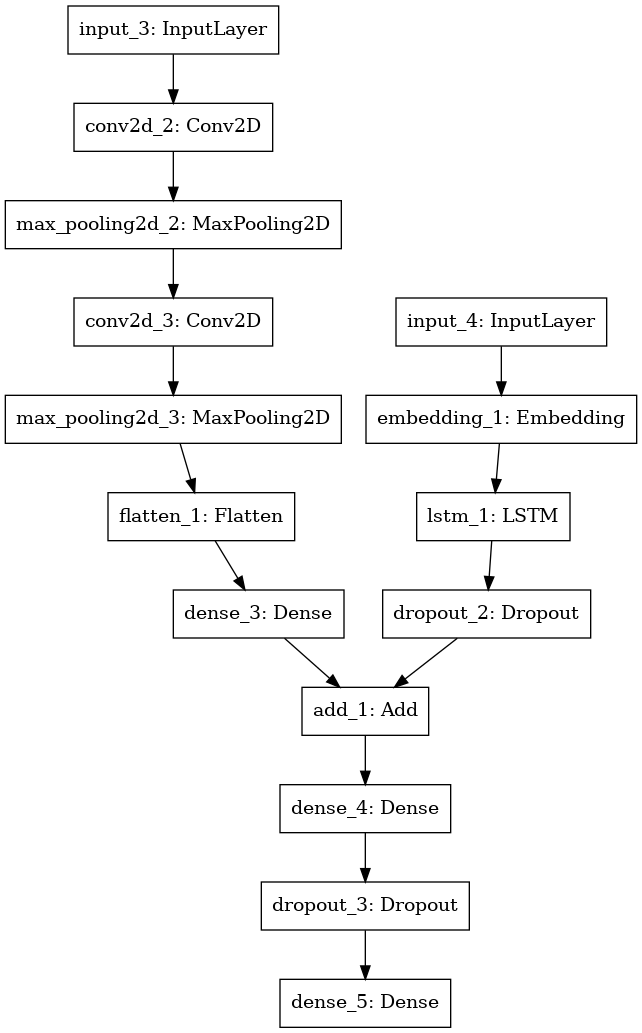

In [26]:
plot_model(audio_model)

In [27]:
audio_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 16, 8, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 16, 8, 16)    160         input_3[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)  (None, 8, 4, 16)     0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 33)]         0                                            
____________________________________________________________________________________________

In [28]:
history = audio_model.fit(X_train,y_train,
        epochs=50,
        batch_size = 32,
        validation_data=(X_test,y_test),
        validation_batch_size = 32)

2022-10-09 16:18:56.545473: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-10-09 16:18:58.156182: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


46/50 [==========================>...] - ETA: 0s - loss: 8.3524

2022-10-09 16:18:59.456719: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 554253488 exceeds 10% of free system memory.
2022-10-09 16:19:00.121594: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 554253488 exceeds 10% of free system memory.


50/50 [==============================] - 6s 79ms/step - loss: 8.3199 - val_loss: 8.0608
Epoch 2/50
50/50 [==============================] - 2s 46ms/step - loss: 7.2741 - val_loss: 7.9671
Epoch 3/50
50/50 [==============================] - 2s 46ms/step - loss: 6.9859 - val_loss: 8.1134
Epoch 4/50
50/50 [==============================] - 2s 46ms/step - loss: 6.8262 - val_loss: 8.5920
Epoch 5/50
50/50 [==============================] - 2s 50ms/step - loss: 6.6622 - val_loss: 8.3553
Epoch 6/50
50/50 [==============================] - 2s 46ms/step - loss: 6.5294 - val_loss: 8.4310
Epoch 7/50
50/50 [==============================] - 2s 46ms/step - loss: 6.4310 - val_loss: 8.7029
Epoch 8/50
50/50 [==============================] - 2s 46ms/step - loss: 6.2932 - val_loss: 8.9251
Epoch 9/50
50/50 [==============================] - 2s 45ms/step - loss: 6.1612 - val_loss: 8.9024
Epoch 10/50
50/50 [==============================] - 2s 50ms/step - loss: 6.0534 - val_loss: 8.8014
Epoch 11/50
50/50 [=

## Making predictions on training and testing data

In [30]:
def idx_to_word(integer,tokenizer):
    for word, index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None

#### Training data evaluation

In [31]:
for j in range(10):
    in_text = "start"
    feature = create_mfcc_features(wav_path[j])
    feature = feature.reshape(1,16,8,1)
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)

        y_pred = audio_model.predict([feature,sequence])
        y_pred = np.argmax(y_pred)
        
        word = idx_to_word(y_pred, tokenizer)
        
        if word is None:
            break
            
        in_text+= " " + word
        
        if word == 'end':
            break
    print("actual:",prompts[j])
    print("Predicted:",in_text)
    print("\n")
    

actual: start videmment comment pouvait conna tre puisque hasard canisme secret cette lampe end
Predicted: start videmment comment pouvait conna tre puisque hasard canisme secret lampe end


actual: start alise presque id al entend angleterre mot respectable convenable gris tre end
Predicted: start alise presque angleterre angleterre angleterre convenable convenable gris tre end


actual: start cet argent bien voici toute chose jais blanc vient norv ge end
Predicted: start bien argent bien bien argent bien bien argent bien bien bien vient norv ge end


actual: start toute vie concentrait cette heure asseyait pr end
Predicted: start toute toute toute concentrait cette heure asseyait pr end


actual: start deux heures pourrai quitter place apr avoir enlev derniers vestiges installation petite affaire end
Predicted: start deux heures pourrai place apr enlev derniers vestiges installation petite end


actual: start sol tait effondr dallage croul gout tait chang puits perdu trouvait plus so

#### Testing data evaluation

In [32]:
for j in range(1800,1810):
    in_text = "start"
    feature = create_mfcc_features(wav_path[j])
    feature = feature.reshape(1,16,8,1)
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)

        y_pred = audio_model.predict([feature,sequence])
        y_pred = np.argmax(y_pred)
        
        word = idx_to_word(y_pred, tokenizer)
        
        if word is None:
            break
            
        in_text+= " " + word
        
        if word == 'end':
            break
    print("actual:",prompts[j])
    print("Predicted:",in_text)
    print("\n")
    

actual: start trouvait nouveau face tres prot ars lupin sous action directe influence end
Predicted: start bout bout bout bout baron hicules baron neuilly end


actual: start voir entrer autres posta aguets derri re tas blais rage patiente chien arr end
Predicted: start assez tait tout minute minute minute minute minute minute minute chang minute minute oublie assez end


actual: start dix derniers si cles travaill sans pouvoir terminer plus pu finir paris end
Predicted: start vieux tait emporter portefeuille monnaie monnaie gousset gilet end


actual: start encore encombr sens dessus dessous air champ bataille joies veille end
Predicted: start treize vu cent sang bien alors end


actual: start ressemblait sens marchait comme instant cygnes nageaient end
Predicted: start toujours re chance toujours chance chance toujours chance qualit docteur end


actual: start ob issance ici consistait souvenir marius oubliait aucun effort faire cela end
Predicted: start retour voulu installer chevet